In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('./data_csv/historical_weather.csv')
print(df.head(1))
print(df.count())

  city_id        date  avg_temp_c  min_temp_c  max_temp_c  precipitation_mm  \
0    C001  2014-01-01         6.6        -1.4        11.6               NaN   

   snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  
0            NaN             168.0                 6.2  
city_id               182338
date                  182338
avg_temp_c            181114
min_temp_c            176452
max_temp_c            174845
precipitation_mm      112594
snow_depth_mm          12238
avg_wind_dir_deg      146944
avg_wind_speed_kmh    159866
dtype: int64


In [41]:
def plot_correlation(correlation, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(correlation, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.xticks(np.arange(len(correlation.columns)),
               correlation.columns, rotation=90)
    plt.yticks(np.arange(len(correlation.columns)), correlation.columns)
    plt.show()

In [42]:
correlation = df[['avg_temp_c', 'min_temp_c', 'max_temp_c',
                  'snow_depth_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh']].corr()
# print(correlation.head(1))

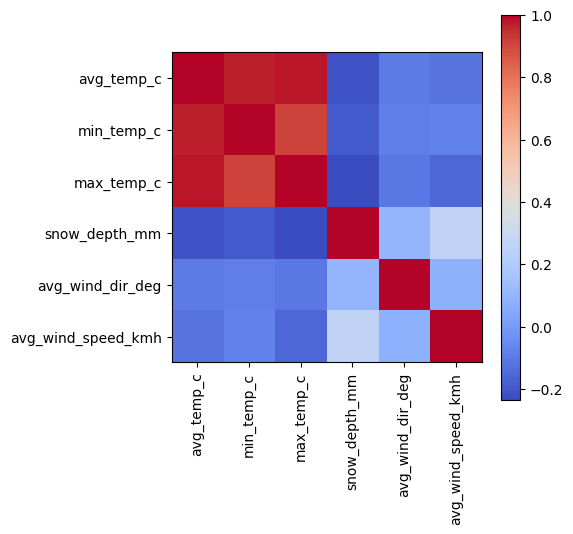

In [43]:
# Assuming that 'correlation' is your correlation matrix
plot_correlation(correlation)

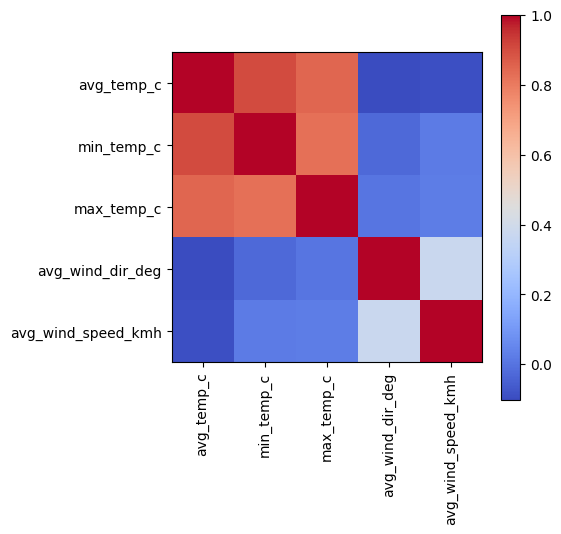

In [44]:
correlation = df[['avg_temp_c', 'min_temp_c', 'max_temp_c', 'avg_wind_dir_deg', 'avg_wind_speed_kmh']].fillna(-1).corr()
plot_correlation(correlation)

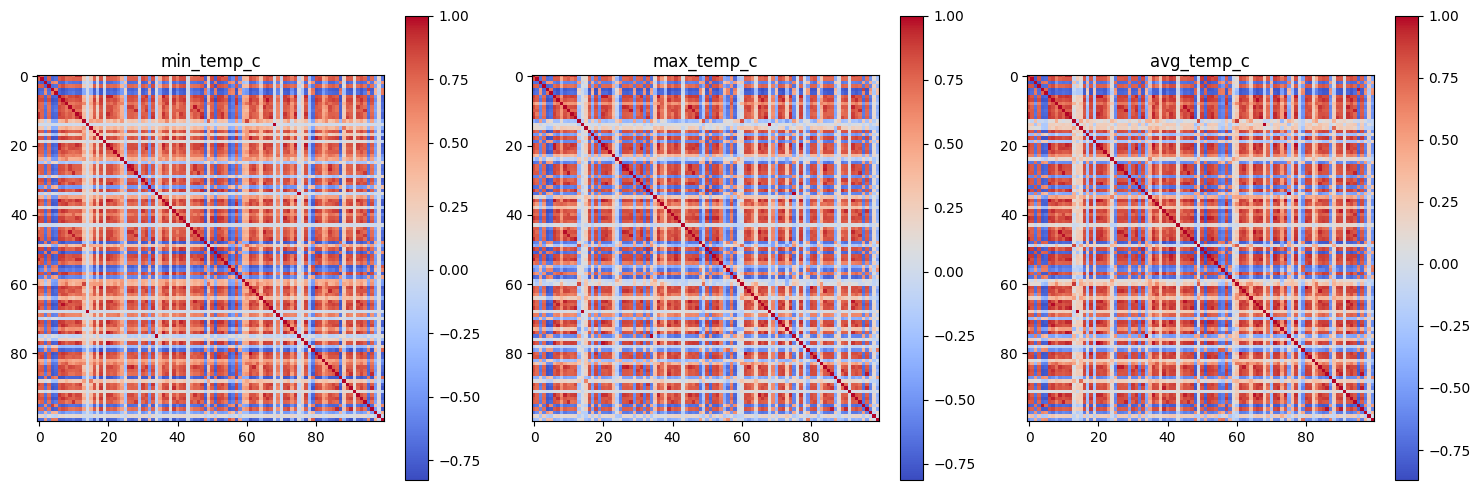

In [55]:
def sub_plot_correlation(correlation, subplot_position, title):
    plt.subplot(1, 3, subplot_position)
    plt.imshow(correlation, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.title(title)


plt.figure(figsize=(15, 5))

temp_types = ['min_temp_c', 'max_temp_c', 'avg_temp_c']
for i, temp_type in enumerate(temp_types, 1):
    df_pivot = df.pivot(index='date', columns='city_id', values=temp_type)
    correlation = df_pivot.corr()
    sub_plot_correlation(correlation, i, temp_type)

plt.tight_layout()
plt.show()

In [4]:
df['date'] = pd.to_datetime(
    df['date'], format='%Y-%m-%d')

In [11]:
# Generate features for each city
def create_features(df):
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['month'] = df['date'].dt.month
    df['week'] = df['date'].dt.isocalendar().week
    df['city'] = df['city_id'].str.extract(r'(\d+)').astype(int)    
    
    for lag in [1, 3, 7]:
        df[f'avg_temp_lag_{lag}'] = df['avg_temp_c'].shift(lag)
        df[f'min_temp_lag_{lag}'] = df['min_temp_c'].shift(lag)
        df[f'max_temp_lag_{lag}'] = df['max_temp_c'].shift(lag)
        df[f'precipitation_lag_{lag}'] = df['precipitation_mm'].shift(lag)
        df[f'snow_depth_lag_{lag}'] = df['snow_depth_mm'].shift(lag)
        df[f'wind_dir_deg_lag_{lag}'] = df['avg_wind_dir_deg'].shift(lag)
        df[f'wind_speed_lag_{lag}'] = df['avg_wind_speed_kmh'].shift(lag)

    for window in [7]:
        df[f'avg_temp_rolling_mean_{window}'] = df['avg_temp_c'].rolling(
            window=window).mean()
        df[f'max_temp_rolling_max_{window}'] = df['max_temp_c'].rolling(
            window=window).max()
        df[f'min_temp_rolling_min_{window}'] = df['min_temp_c'].rolling(
            window=window).min()
        df[f'precipitation_rolling_sum_{window}'] = df['precipitation_mm'].rolling(
            window=window).sum()
        df[f'snow_depth_rolling_mean_{window}'] = df['snow_depth_mm'].rolling(
            window=window).mean()
        df[f'wind_speed_rolling_mean_{window}'] = df['avg_wind_speed_kmh'].rolling(
            window=window).mean()
        df[f'wind_dir_rolling_mean_{window}'] = df['avg_wind_dir_deg'].rolling(
            window=window).mean()

    df['temp_range'] = df['max_temp_c'] - df['min_temp_c']

    return df


# Apply feature creation to each city
data = df.groupby('city_id').apply(create_features).reset_index(drop=True)

In [12]:
data.to_csv('./derived_data_csv/new_features_added.csv', index=False)

In [9]:
# Generate features for each city
def create_features(df):
    df['city'] = df['city_id'].str.extract(r'(\d+)').astype(int)
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['month'] = df['date'].dt.month

    df['temp_range'] = df['max_temp_c'] - df['min_temp_c']

    return df


# Apply feature creation to each city
data2 = df.groupby('city_id').apply(create_features).reset_index(drop=True)

In [10]:
data2.to_csv('./derived_data_csv/new_features_added_min.csv', index=False)

In [15]:
# Assuming 'avg_temp_c', 'min_temp_c', and 'max_temp_c' are the temperature-related columns
min_temp = df.groupby('city_id')[
    ['avg_temp_c', 'min_temp_c', 'max_temp_c']].min()
max_temp = df.groupby('city_id')[
    ['avg_temp_c', 'min_temp_c', 'max_temp_c']].max()
avg_temp = df.groupby('city_id')[
    ['avg_temp_c', 'min_temp_c', 'max_temp_c']].mean()

# Combine the DataFrames into a single DataFrame
temp_stats = pd.concat([min_temp, max_temp, avg_temp],
                       axis=1, keys=['min', 'max', 'avg'])

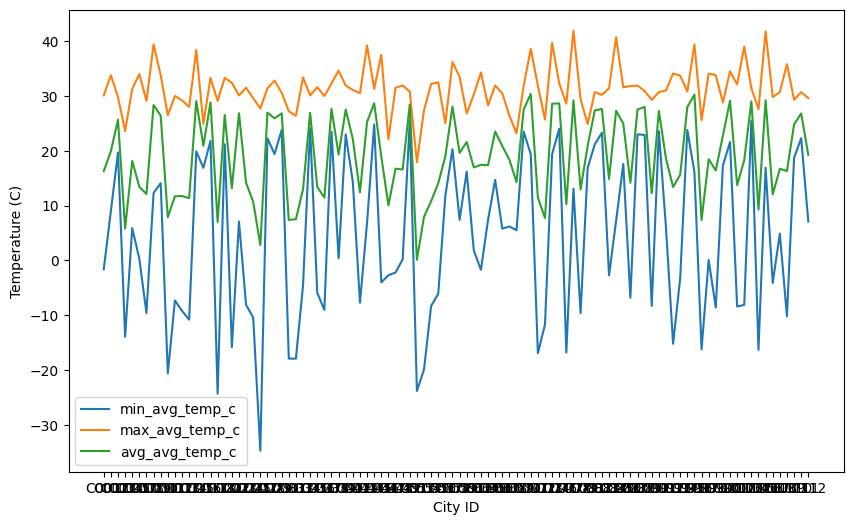

In [14]:
# Reshape the DataFrame
temp_stats.columns = ['_'.join(col) for col in temp_stats.columns.values]
temp_stats.reset_index(inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))

for column in ['min_avg_temp_c', 'max_avg_temp_c', 'avg_avg_temp_c']:
    plt.plot(temp_stats['city_id'], temp_stats[column], label=column)

plt.xlabel('City ID')
plt.ylabel('Temperature (C)')
plt.legend()

plt.show()